## Part 02: Export nodes and select working streets
michael babb  
2024 11 24

In [1]:
# standard
import os
import collections

In [2]:
# external
from concave_hull import concave_hull
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from shapely import Point, MultiPoint

In [3]:
# custom
import run_constants as rc
from utils import create_name, generate_street_end_vertices, write_gdf, write_json

# load the street network

In [4]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S02_SND_IN_FILE_NAME)

In [5]:
gdf = gpd.read_file(filename = fpn)

In [6]:
gdf.shape

(34378, 39)

In [7]:
gdf['ord_stname_unique'].unique().shape

(3696,)

# generate street end vertices - these will be helpful with identification in subsequent steps

In [8]:
# can we generate the vertices? yes... but let's check what type of geometry we are working with
gdf['geometry'].map(lambda x: x.geom_type).value_counts()

geometry
MultiLineString    34378
Name: count, dtype: int64

In [9]:
# everything is a MultLineString??? is that necessary?
# we can call the gdf.explode() function to convert MultiLineStrings to LineStrings
# if the record counts are the same, we can convert everything to LineStrings 
test_gdf = gdf.explode()

In [10]:
test_gdf.shape

(34378, 39)

In [11]:
# nope! The number of records is the same, indicating that MultiLineStrings are not necessary
gdf = test_gdf.copy()

In [12]:
gdf['geometry'].geom_type.value_counts()

LineString    34378
Name: count, dtype: int64

In [13]:
gdf, node_gdf = generate_street_end_vertices(gdf = gdf)

In [14]:
write_gdf(gdf = node_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name= rc.S02_NODE_OUT_FILE_NAME)

# import the manually classified streets to update streets without a classification. 

In [15]:
fpn = os.path.join(rc.INPUT_FILE_PATH, rc.S02_BST_IN_FILE_NAME)

In [16]:
blank_street_type_df = pd.read_excel(io = fpn)

In [17]:
blank_street_type_df.head()

,ord_stname_concat,ord_street_type_fix
0,17TH AVE NW WKWY,WKWY
1,21ST AV SW TURN,RN
2,59TH AV SW TURN,ST
3,AIRPORT FY NB,SR
4,AIRPORT FY SB,SR


In [18]:
blank_street_type_df.shape

(80, 2)

In [19]:
gdf.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'citycode',
       'stname_id', 'st_code', 'arterial_code', 'segment_type', 'agency_code',
       'access_code', 'divided_code', 'structure_type', 'legalloc_code',
       'vehicle_use_code', 'gis_seg_length', 'l_adrs_from', 'l_adrs_to',
       'r_adrs_from', 'r_adrs_to', 'ord_pre_dir', 'ord_street_name',
       'ord_street_type', 'ord_suf_dir', 'ord_stname_concat', 'l_city',
       'l_state', 'l_zip', 'r_city', 'r_state', 'r_zip', 'sndseg_update',
       'compkey', 'comptype', 'unitid', 'unitid2', 'city_portion',
       'ord_stname_unique', 'geometry'],
      dtype='object')

In [20]:
test_join = pd.merge(left = gdf, right = blank_street_type_df, how = 'outer', indicator = True)

In [21]:
test_join['_merge'].value_counts()

_merge
left_only     33662
both            716
right_only        0
Name: count, dtype: int64

In [22]:
gdf = test_join.copy()

In [23]:
gdf.loc[gdf['ord_street_type'].isna(), 'ord_street_type'] = gdf.loc[gdf['ord_street_type'].isna(), 'ord_street_type_fix']

In [24]:
gdf['ord_street_type'].unique()

array(['RP', 'AVE', 'LN', 'PL', 'TER', 'RD', 'CT', 'BR', 'WKWY', 'TRL',
       'RN', 'ST', 'ET', 'DR', 'CIR', 'PKWY', 'SR', 'WAY', 'AL', 'RR',
       'BLVD', 'OP', 'STCR', 'IS', 'MALL', 'PZ', 'LOOP', 'FLYOVER',
       'VIEW', 'HWY'], dtype=object)

In [25]:
gdf['ord_street_type'].isna().value_counts()

ord_street_type
False    34378
Name: count, dtype: int64

In [26]:
gdf = gdf.drop(labels = ['ord_street_type_fix', '_merge'], axis = 1)

# keep only streets in Seattle

In [27]:
gdf = gdf.loc[(gdf['l_city'] == 'SEATTLE') |
(gdf['r_city'] == 'SEATTLE'), :].copy()

In [28]:
gdf.shape

(27891, 39)

In [29]:
gdf['ord_stname_concat'].unique().shape

(2795,)

# write the full seattle streets to disk

In [30]:
write_gdf(gdf = gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S02_SND_FULL_OUT_FILE_NAME)

# keep only streets with segment_type == 1  
These are actual streets.  
Everything else not a street (rail, trail, staircase, etc...).  
`segment_type == 15` is a stub, a dangling piece of a street, usually around 50 feet or less.  
Very short! There are 362 of them.

In [31]:
gdf['segment_type'].value_counts()

segment_type
1     25789
15      362
7       350
6       332
4       215
3       205
8       203
9       175
13      126
2        49
5        45
11       33
10        5
12        1
14        1
Name: count, dtype: int64

In [32]:
# before...
gdf.shape

(27891, 39)

In [33]:
gdf = gdf.loc[gdf['segment_type'] == 1, :].copy()
# after...
gdf.shape

(25789, 39)

In [34]:
gdf['ord_stname_unique'].unique().shape

(2462,)

# update the city portion variable

In [35]:
# we can quickly identify the central streets by performing some analysis in qGIS, 
fpn = os.path.join(rc.INPUT_FILE_PATH, rc.S02_CENTRAL_STREETS_IN_FILE_NAME)
cs_df = pd.read_csv(filepath_or_buffer=fpn)


In [36]:
# check
cs_df.head()

,snd_id,temp_city_portion
0,11524,CNTR
1,16184,CNTR
2,16185,CNTR
3,16187,CNTR
4,16289,CNTR


In [37]:
# join
test_join = pd.merge(left = gdf, right = cs_df, how = 'outer', indicator = True)
test_join['_merge'].value_counts()

_merge
left_only     24082
both           1707
right_only        0
Name: count, dtype: int64

In [38]:
test_join['ord_stname_unique'].unique().shape

(2462,)

In [39]:
check_df = test_join[['ord_stname_unique', 'city_portion']].drop_duplicates()

In [40]:
my_counter = collections.Counter(check_df['ord_stname_unique'])

In [41]:
test_join.columns

Index(['f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode', 'citycode',
       'stname_id', 'st_code', 'arterial_code', 'segment_type', 'agency_code',
       'access_code', 'divided_code', 'structure_type', 'legalloc_code',
       'vehicle_use_code', 'gis_seg_length', 'l_adrs_from', 'l_adrs_to',
       'r_adrs_from', 'r_adrs_to', 'ord_pre_dir', 'ord_street_name',
       'ord_street_type', 'ord_suf_dir', 'ord_stname_concat', 'l_city',
       'l_state', 'l_zip', 'r_city', 'r_state', 'r_zip', 'sndseg_update',
       'compkey', 'comptype', 'unitid', 'unitid2', 'city_portion',
       'ord_stname_unique', 'geometry', 'temp_city_portion', '_merge'],
      dtype='object')

In [42]:
test_join.loc[test_join['_merge'] == 'both', 'city_portion'] = \
test_join.loc[test_join['_merge'] == 'both', 'temp_city_portion']

In [43]:
test_join['ord_stname_unique'] = test_join.apply(func = create_name, axis = 1)

In [44]:
# drop and overwrite
drop_col_names = ['temp_city_portion', '_merge']
gdf = test_join.drop(labels = drop_col_names, axis = 1).copy()

In [45]:
write_gdf(gdf = test_join, output_file_path = rc.OUTPUT_FILE_PATH, output_file_name='test_fucker.gpkg')

# draw a convex hull around each group of city streets

In [46]:
data_list = []
geom_list = []
for cp in gdf['city_portion'].unique().tolist():
    print(cp)
    temp_geoms = gdf.loc[gdf['city_portion'] == cp, 'geometry']
    
    # create the convex hull around the points    
    geom_point_list = []
    point_list = []
    for curr_line in temp_geoms:
        for curr_coords in curr_line.coords:
            geom_point_list.append(Point(curr_coords))
            point_list.append(curr_coords)
    
    cvx_hull = shapely.convex_hull(geometry = MultiPoint(geom_point_list))
    print(type(cvx_hull))
    
    temp_list = [cp, 'convex']
    data_list.append(temp_list)
    geom_list.append(cvx_hull)

    # create a concave hull
    ch = concave_hull(points = point_list)
    my_poly = shapely.Polygon(ch)
    data_list.append([cp, 'concave'])
    geom_list.append(my_poly)

NW
<class 'shapely.geometry.polygon.Polygon'>
N
<class 'shapely.geometry.polygon.Polygon'>
NE
<class 'shapely.geometry.polygon.Polygon'>
CNTR
<class 'shapely.geometry.polygon.Polygon'>
E
<class 'shapely.geometry.polygon.Polygon'>
W
<class 'shapely.geometry.polygon.Polygon'>
S
<class 'shapely.geometry.polygon.Polygon'>
SW
<class 'shapely.geometry.polygon.Polygon'>


In [47]:
# build a geodataframe
output_gdf = gpd.GeoDataFrame(data = data_list, columns = ['city_portion', 'hull_type'], geometry = geom_list, crs = 'epsg:4326')
# fix any odd geometries
output_gdf['geometry'] = output_gdf['geometry'].make_valid()

In [48]:
# now, let's project to WGS 84 UTM Zone 10N to perform some area calculation

In [49]:
output_gdf = output_gdf.to_crs(epsg=32610)

In [50]:
output_gdf.head()

,city_portion,hull_type,geometry
0,NW,convex,"POLYGON ((548235.329 5277837.611, 548223.346 5..."
1,NW,concave,"MULTIPOLYGON (((548260.471 5278459.705, 548236..."
2,N,convex,"POLYGON ((550121.707 5274117.103, 550025.382 5..."
3,N,concave,"MULTIPOLYGON (((548236.706 5277549.869, 548236..."
4,NE,convex,"POLYGON ((552225.631 5277355.758, 551813.827 5..."


In [51]:
def keep_largest_geometry(gdf:gpd.GeoDataFrame,group_col_names:list = None):
        
    # explode
    gdf = gdf.explode()
    keep_col_names = gdf.columns
    # select only Polygon or MultiPolygon geometries
    gdf = gdf.loc[gdf['geometry'].geom_type.isin(['Polygon', 'MultiPolygon']), :]
    gdf['geom_area'] = gdf['geometry'].area
    # keep the biggest pieces / remove slivers    
    if group_col_names is None:
        gdf['area_rank'] = gdf['geom_area'].rank(method = 'dense', ascending=False)
    else:
        gdf['area_rank'] = gdf.groupby(group_col_names)['geom_area'].rank(method = 'dense', ascending=False)
    
    # keep the largest, drop the area_rank column
    gdf = gdf.loc[gdf['area_rank'] == 1, keep_col_names]

    return gdf

In [52]:
output_gdf = keep_largest_geometry(gdf = output_gdf, group_col_names=['city_portion', 'hull_type'])

In [53]:
output_gdf.head()

,city_portion,hull_type,geometry
0,NW,convex,"POLYGON ((548235.329 5277837.611, 548223.346 5..."
1,NW,concave,"POLYGON ((544560.158 5280213.434, 544559.88 52..."
2,N,convex,"POLYGON ((550121.707 5274117.103, 550025.382 5..."
3,N,concave,"POLYGON ((548236.706 5277549.869, 548236.48 52..."
4,NE,convex,"POLYGON ((552225.631 5277355.758, 551813.827 5..."


In [54]:
# TODO: fix the multi polygon issue

In [55]:
# okay, cool. We have the lines. So, let's go back to the polygons. 
p_gdf = output_gdf.copy()

In [58]:
output_gdf = output_gdf.to_crs(epsg = 4326)

In [60]:
# save it!
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S02_CITY_SECTIONS_OUT_FILE_NAME)

In [61]:
# let's export this to a LineString file as well
output_gdf['geometry'] = output_gdf['geometry'].boundary
output_gdf['geometry'] = output_gdf['geometry'].make_valid()

In [62]:
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH, 
          output_file_name=rc.S02_CITY_SECTIONS_LINES_OUT_FILE_NAME)

In [63]:
# let's get weird with buffers

In [64]:
# keep only the concave bulls
p_gdf = p_gdf.loc[p_gdf['hull_type'] == 'concave', :]

<Axes: >

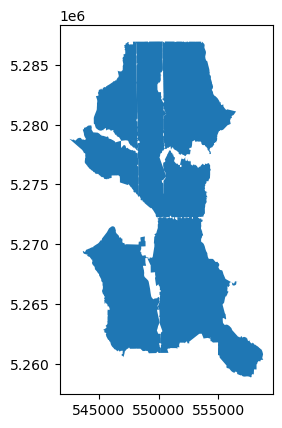

In [65]:
p_gdf.plot()

In [66]:
p_gdf.head()

,city_portion,hull_type,geometry
1,NW,concave,"POLYGON ((544560.158 5280213.434, 544559.88 52..."
3,N,concave,"POLYGON ((548236.706 5277549.869, 548236.48 52..."
5,NE,concave,"POLYGON ((550433.919 5278501.622, 550442.898 5..."
7,CNTR,concave,"POLYGON ((548285.033 5274027.51, 548284.855 52..."
9,E,concave,"POLYGON ((550377.214 5276766.109, 550410.608 5..."


In [67]:
# we first need to reproject
# and then: intersect the data so that it's nice and clean. So clean. 

In [68]:
# here is what needs to be intersected:
# N and CNTR and E and CNTR
g_names = ['N', 'CNTR', 'E']
geom_dict = {}
for gn in g_names:
    geom_dict[gn] = p_gdf.loc[p_gdf['city_portion'] == gn, 'geometry'].iloc[0]

In [69]:
# time to do an intersection!
# north / center geometry
nc_geom = geom_dict['N'].intersection(geom_dict['CNTR'])
# east / center geometry
ec_geom = geom_dict['E'].intersection(geom_dict['CNTR'])

# the isolated center geometry
c_geom = geom_dict['CNTR'].difference(geom_dict['N'])
c_geom = c_geom.difference(geom_dict['E'])

# we also need only the north and east geometry
# north / center geometry
nc_diff_geom = geom_dict['N'].difference(geom_dict['CNTR'])
# east / center geometry
ec_diff_geom = geom_dict['E'].difference(geom_dict['CNTR'])



In [70]:
# gather and create a geodataframe
geom_list = [c_geom, nc_geom, ec_geom, nc_diff_geom, ec_diff_geom]
data_list = ['CNTR', 'NC', 'EC', 'N', 'E']
mod_gdf = gpd.GeoDataFrame(data = {'city_portion':data_list},
                           geometry = geom_list, crs = 32610)

In [71]:
# clean up the geometries
mod_gdf = keep_largest_geometry(gdf = mod_gdf, group_col_names=['city_portion'])

In [72]:
mod_gdf.head()

,city_portion,geometry
0,CNTR,"POLYGON ((548207.446 5274110.047, 548205.081 5..."
1,NC,"POLYGON ((548236.48 5277575.735, 548237.788 52..."
2,EC,"POLYGON ((553990.355 5274053.615, 554005.492 5..."
3,N,"POLYGON ((548236.052 5277648.077, 548281.925 5..."
4,E,"POLYGON ((550410.608 5276841.828, 550415.26 52..."


In [73]:
# add them to the other geodataframe with the good geometry:
p_gdf.head()

,city_portion,hull_type,geometry
1,NW,concave,"POLYGON ((544560.158 5280213.434, 544559.88 52..."
3,N,concave,"POLYGON ((548236.706 5277549.869, 548236.48 52..."
5,NE,concave,"POLYGON ((550433.919 5278501.622, 550442.898 5..."
7,CNTR,concave,"POLYGON ((548285.033 5274027.51, 548284.855 52..."
9,E,concave,"POLYGON ((550377.214 5276766.109, 550410.608 5..."


In [74]:
mod_gdf['hull_type'] = 'concave'

In [75]:
col_names = p_gdf.columns.tolist()
mod_gdf = mod_gdf[col_names]

In [76]:
p_gdf = p_gdf.loc[-p_gdf['city_portion'].isin(mod_gdf['city_portion']), :]

In [77]:
p_gdf = pd.concat(objs = [p_gdf, mod_gdf], axis = 0)

In [78]:
p_gdf = p_gdf.to_crs(epsg=4326)

In [79]:
write_gdf(gdf = p_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='test_split.gpkg')

In [80]:
# convert back to WGS 84 UTM Zone 10 N, for buffering
p_gdf = p_gdf.to_crs(epsg = 32610)

In [81]:
def build_gdf_from_geom(geom:shapely.geometry, remove_slivers:bool=True, crs:int=4326):
    gdf = gpd.GeoDataFrame(data = {'id':[0]}, geometry=[geom], crs = crs)
    if remove_slivers:
        gdf = keep_largest_geometry(gdf = gdf)
    return gdf


In [82]:
# let's do some fun inner buffering
output_data_list = []
output_geom_list = []

output_line_data_list = []
output_line_geom_list = []
for ir, row in p_gdf.iterrows():
    city_portion = row['city_portion']
    print(city_portion)
    geom = row['geometry']
    perim = geom.boundary
    previous_buff_dict = {}
    for i_dist in range(10, 101, 10):
        my_buff = perim.buffer(distance= i_dist)
        # clip it
        my_buff = my_buff.intersection(geom)
        # this is the stuff on the inside of the ring
        my_buff = build_gdf_from_geom(geom = my_buff, crs = p_gdf.crs)        
        my_buff = my_buff['geometry'].iloc[0]
        previous_buff_dict[i_dist] = my_buff

        # now, clip it to the previous buffer
        if i_dist > 10:
            previous_disk = previous_buff_dict[i_dist - 10] 
            my_buff = my_buff.difference(previous_disk)

            my_buff = build_gdf_from_geom(geom = my_buff, crs = p_gdf.crs)        
            my_buff = my_buff['geometry'].iloc[0]                              

        temp_list = [city_portion, i_dist]
        output_data_list.append(temp_list)
        output_geom_list.append(my_buff)

        line_index = 0
        for line_geom in my_buff.boundary.geoms:
            curr_list = temp_list[:]
            curr_list.append(line_index)
            output_line_data_list.append(curr_list)
            output_line_geom_list.append(line_geom)
            line_index += 1


output_gdf = gpd.GeoDataFrame(data = output_data_list, geometry = output_geom_list,
                              crs = 'epsg:32610', columns = ['city_portion', 'distance'])

output_gdf = output_gdf.to_crs(epsg = 4326)

output_line_gdf = gpd.GeoDataFrame(data = output_line_data_list, geometry = output_line_geom_list,
                              crs = 'epsg:32610', columns = ['city_portion', 'distance', 'line_index'])
output_line_gdf = output_line_gdf.to_crs(epsg = 4326)

NW
NE
W
S
SW
CNTR
NC
EC
N
E


In [83]:
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='test_inner_buffer.gpkg')
write_gdf(gdf = output_line_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name='test_inner_line_buffer.gpkg')

In [ ]:
# WGS 84 UTM ZONE 10 N: EPSG:32610

In [ ]:
temp_output_gdf = output_line_gdf.copy()
temp_output_gdf.columns = ['cp', 'dist', 'li', 'geometry']
temp_output_gdf['cp'] = temp_output_gdf['cp'].str.replace('CNTR', 'C')
cs_json = temp_output_gdf.to_json(drop_id=True, to_wgs84=True)


In [ ]:
# let's save this to a geojson
write_json(json_data=cs_json, output_file_path='../maps', output_file_name='city_section_lines.geojson',
           var_name = None)

# remove the following streets types:

AL: alley  
TRL: trail  
OP: overpass  
IS: interstate  
SR: state route  
RR: rail  
FLYOVER: flyover  
STCR: streetcar  
ET: extension  
RN: turn  
RP: highway ramps  
WKWY: walkways  

In [ ]:
# remove streets of the following type
street_type_to_remove = [ 'AL', 'TRL', 'OP', 'IS', 'SR', 'RR', 'FLYOVER',
                         'STCR', 'ET', 'RN', 'RP', 'WKWY']

In [ ]:
# before...
gdf.shape

In [ ]:
# what street types are left?
gdf['ord_street_type'].unique()

In [ ]:
# remove...
gdf = gdf.loc[-gdf['ord_street_type'].isin(street_type_to_remove), :].copy()

In [ ]:
# after..
gdf.shape

In [ ]:
# what street types are left?
gdf['ord_street_type'].unique()

# remove other short segments that appear to be invalid.

In [ ]:
# uncomment to remove the erroneous segments
err_segments = pd.read_csv(filepath_or_buffer='../data/streets_to_remove.txt')


In [ ]:
# examine the erroneous segments
tgdf = gdf.loc[gdf['snd_id'].isin(err_segments['snd_id']), :].copy()
tgdf['gis_seg_length'].describe()
# very short!

In [ ]:
# check names...
tgdf['ord_stname_concat'].unique().tolist()

In [ ]:
tgdf['segment_type'].unique()

In [ ]:
tgdf.head()

In [ ]:
# remove the erroneous segments
gdf = gdf.loc[-gdf['snd_id'].isin(err_segments['snd_id']), :].copy()

In [ ]:
# after
gdf.shape

In [ ]:
# unique roads
gdf['ord_stname_unique'].unique().shape

In [ ]:
# total miles in Seattle, based on select road ways
gdf['gis_seg_length'].sum() / 5280

# save as a gdf - overwrite

In [ ]:
write_gdf(gdf = gdf, output_file_path = rc.OUTPUT_FILE_PATH,
          output_file_name =  rc.S02_SND_WORKING_OUT_FILE_NAME)